In [23]:
import pandas as pd
import utils
import numpy as np
# from astropy.timeseries import BoxLeastSquares
import matplotlib.pyplot as plt
# import lightkurve as lk
from scipy.signal import medfilt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  

### Read in Lightcurve Data

#### Split into Train, Validation and Test (60/20/20)

In [11]:
# from csv file created using utils.collect_curves_tofiles()
all_curves = pd.read_csv('./Data/flux_all_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_all_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_all_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

# train-val-test split 60-20-20 split
X_trainval, X_test, y_trainval, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_val_interp = X_val.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

#### Split into Train and Test (80/20)

In [21]:
# from csv file created using utils.collect_curves_tofiles()
all_curves = pd.read_csv('./Data/flux_all_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_all_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_all_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

### Using SVC with default params

In [12]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_interp, y_train.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [13]:
svc_pred_val = clf.predict(X_val_interp)
svc_pred_train = clf.predict(X_train_interp)
print(f"Train score is {accuracy_score(y_train, svc_pred_train)}")
print(f"Validation score is {accuracy_score(y_val, svc_pred_val)}")

Train score is 0.65
Validation score is 0.675


In [14]:
svc_pred_test = clf.predict(X_test_interp)
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

test accuracy: 0.575


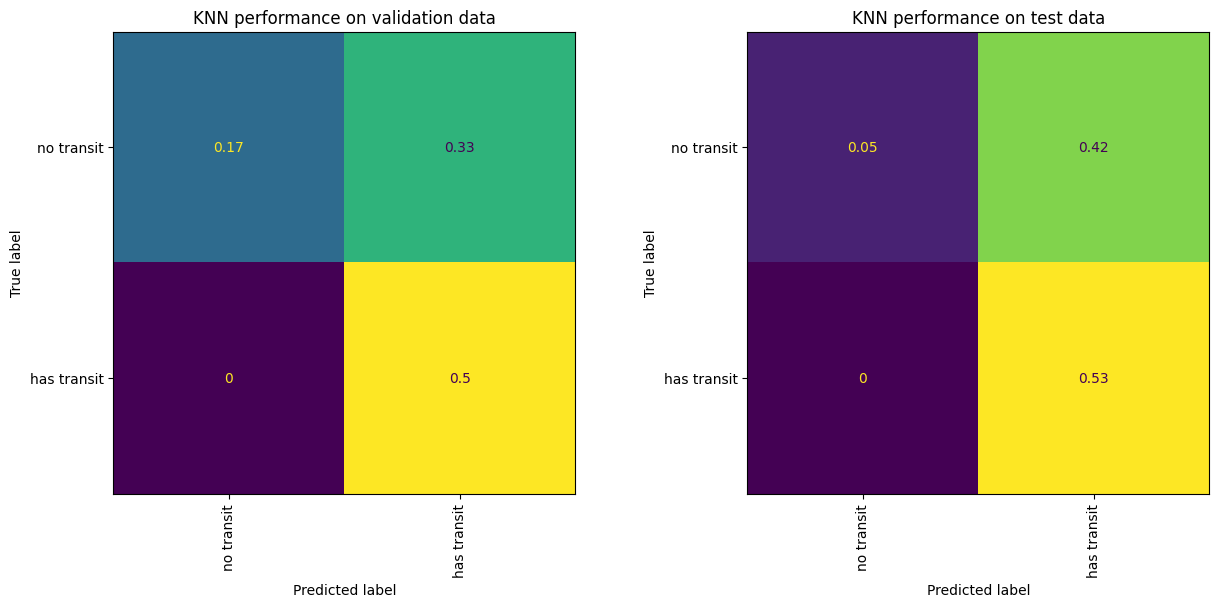

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax1 = plt.subplot(121)
ConfusionMatrixDisplay.from_estimator(clf, X_val_interp, y_val, xticks_rotation='vertical', ax=ax1, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on validation data')
ax2 = plt.subplot(122)
ConfusionMatrixDisplay.from_estimator(clf, X_test_interp, y_test, xticks_rotation='vertical', ax=ax2, normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on test data')
plt.show()

In [19]:
print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

              precision    recall  f1-score   support

           0       1.00      0.11      0.19        19
           1       0.55      1.00      0.71        21

    accuracy                           0.57        40
   macro avg       0.78      0.55      0.45        40
weighted avg       0.77      0.57      0.46        40

Recall score is 1.0


### Use GridSearchCV to find optimal hyperparameter

In [26]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'poly']} 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # 10-fold cross validation
  
grid = GridSearchCV(SVC(), param_grid, refit = True, cv = folds, scoring='recall', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)
  
# fitting the model for grid search
grid.fit(X_train_interp, y_train.ravel())

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             error_score='raise', estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             return_train_score=True, scoring='recall', verbose=1)

In [29]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation recall score is: {grid.best_score_}")

Best hyperparameter is: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best estimator is: SVC(C=1, gamma=1)
Best Validation recall score is: 1.0


##### Results

In [34]:
svc_pred_test = grid.predict(X_test_interp)
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

test accuracy: 0.575


<Figure size 1500x600 with 0 Axes>

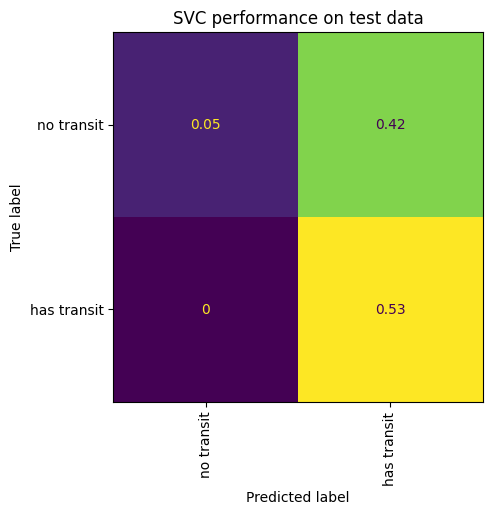

              precision    recall  f1-score   support

           0       1.00      0.11      0.19        19
           1       0.55      1.00      0.71        21

    accuracy                           0.57        40
   macro avg       0.78      0.55      0.45        40
weighted avg       0.77      0.57      0.46        40

Recall score is 1.0


In [35]:
# fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.figure(figsize = [15,6])
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")

## Use Phase-folded smooth data 

In [36]:
# from csv file created using utils.collect_curves_tofiles()
all_curves = pd.read_csv('./Data/flux_phase_1000_50.csv', header = None)
all_times = pd.read_csv('./Data/time_phase_1000_50.csv', header = None)
all_labels = pd.read_csv('./Data/labels_phase_1000_50.csv', header = None)
all_labels = np.array(all_labels).ravel()

X_train, X_test, y_train, y_test = train_test_split(all_curves, all_labels, test_size=0.2, random_state=321)

# fill in Nans
X_train_interp = X_train.interpolate(limit_direction='both', axis = 1)
X_test_interp = X_test.interpolate(limit_direction='both', axis = 1)

### Use GridSearchCV to find optimal hyperparameter

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'poly']} 

folds = KFold(n_splits = 10, shuffle = True, random_state = 100) # 10-fold cross validation
  
grid = GridSearchCV(SVC(), param_grid, refit = True, cv = folds, scoring='recall', verbose = 1, return_train_score=True, error_score='raise', n_jobs=-1)
  
# fitting the model for grid search
grid.fit(X_train_interp, y_train.ravel())

In [ ]:
# print best parameter after tuning
print(f"Best hyperparameter is: {grid.best_params_}")

# print how our model looks after hyper-parameter tuning
print(f"Best estimator is: {grid.best_estimator_}")

print(f"Best Validation recall score is: {grid.best_score_}")

##### Results

In [ ]:
svc_pred_test = grid.predict(X_test_interp)
print('test accuracy:', np.round(accuracy_score(y_test , svc_pred_test),4))

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.figure(figsize = [15,6])
ConfusionMatrixDisplay.from_estimator(grid, X_test_interp, y_test, xticks_rotation='vertical', normalize = 'all', display_labels=['no transit','has transit'], colorbar=False)
#plot_confusion_matrix(knn, X_val, y_val, ax=ax, display_labels=['no transit','has transit'], xticks_rotation='vertical') # are the labels right??
plt.title('SVC performance on test data')
plt.show()

print(classification_report(y_test, svc_pred_test))
print(f"Recall score is {recall_score(y_pred=svc_pred_test, y_true=y_test)}")